
# Final Grid Pathfinding Benchmark (A\*, Dijkstra, DFS, JPS) 



In [1]:

# Imports, artifact folder, manifest
import os, sys, time, math, random
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any, Callable, Optional
from heapq import heappush, heappop

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
try:
    import psutil
except Exception:
    psutil = None

ARTIFACTS = os.path.join('.', 'artifacts_all_in_one')
os.makedirs(ARTIFACTS, exist_ok=True)

def manifest():
    return {
        "python": sys.version.split()[0],
        "numpy": np.__version__,
        "pandas": pd.__version__,
        "matplotlib": plt.matplotlib.__version__,
        "psutil_available": bool(psutil),
    }
print('Manifest:', manifest())


Manifest: {'python': '3.12.3', 'numpy': '1.26.4', 'pandas': '2.2.2', 'matplotlib': '3.8.4', 'psutil_available': True}


In [2]:

# Maze generation
def generate_maze_dfs_seeded(width:int, height:int, seed:int=0)->np.ndarray:
    rng = random.Random(seed)
    maze = np.ones((height,width), dtype=int)
    stack=[(1,1)]
    maze[1,1]=0
    dirs=[(-2,0),(2,0),(0,-2),(0,2)]
    while stack:
        y,x=stack.pop()
        rng.shuffle(dirs)
        for dy,dx in dirs:
            ny,nx=y+dy,x+dx
            if 1<=ny<height-1 and 1<=nx<width-1 and maze[ny,nx]==1:
                maze[ny,nx]=0
                maze[y+dy//2,x+dx//2]=0
                stack.append((ny,nx))
    maze[1,1]=0
    maze[height-2,width-2]=0
    return maze

def add_loops(maze:np.ndarray, p:float, seed:int=0)->np.ndarray:
    rng=np.random.default_rng(seed)
    out=maze.copy()
    H,W=out.shape
    for y in range(1,H-1):
        for x in range(1,W-1):
            if out[y,x]==1 and rng.random()<p:
                out[y,x]=0
    return out

def free_cells(m:np.ndarray)->int:
    return int(np.sum(m==0))

def hygiene()->None:
    import gc; gc.collect(); time.sleep(0.0)


In [3]:

# Algorithms with unified return dict

def dfs_metrics(maze:np.ndarray, start:Tuple[int,int], end:Tuple[int,int])->Dict[str,Any]:
    H,W=maze.shape
    visited=np.zeros((H,W),dtype=bool)
    visited[start]=True
    stack=[(start[0],start[1],[start])]
    dirs=[(-1,0),(1,0),(0,-1),(0,1)]
    expanded=0; generated=1; peak_frontier=len(stack); peak_closed=0
    expanded_order=[]; pop_times_ns=[]; t0=time.perf_counter_ns()
    while stack:
        y,x,path=stack.pop()
        expanded+=1; peak_closed+=1
        expanded_order.append((y,x))
        pop_times_ns.append(time.perf_counter_ns()-t0)
        peak_frontier=max(peak_frontier,len(stack))
        if (y,x)==end:
            return {"path":path,"nodes_expanded":expanded,"nodes_generated":generated,
                    "peak_frontier":peak_frontier,"peak_closed":peak_closed,
                    "expanded_order":expanded_order,"pop_times_ns":pop_times_ns}
        for dy,dx in dirs:
            ny,nx=y+dy,x+dx
            if 0<=ny<H and 0<=nx<W and maze[ny,nx]==0 and not visited[ny,nx]:
                visited[ny,nx]=True; generated+=1
                stack.append((ny,nx,path+[(ny,nx)]))
                peak_frontier=max(peak_frontier,len(stack))
    return {"path":[],"nodes_expanded":expanded,"nodes_generated":generated,
            "peak_frontier":peak_frontier,"peak_closed":peak_closed,
            "expanded_order":expanded_order,"pop_times_ns":pop_times_ns}

def dijkstra_metrics(maze:np.ndarray, start:Tuple[int,int], end:Tuple[int,int])->Dict[str,Any]:
    H,W=maze.shape
    dist=np.full((H,W),np.inf); dist[start]=0.0
    parent={start:None}
    pq=[(0.0,start)]
    expanded=0; generated=1; peak_frontier=len(pq)
    closed=set(); expanded_order=[]; pop_times_ns=[]; t0=time.perf_counter_ns()
    while pq:
        g,cur=heappop(pq)
        if cur in closed: continue
        closed.add(cur); expanded+=1
        expanded_order.append(cur); pop_times_ns.append(time.perf_counter_ns()-t0)
        peak_frontier=max(peak_frontier,len(pq))
        if cur==end:
            path=[]; x=cur
            while x is not None: path.append(x); x=parent[x]
            path.reverse()
            return {"path":path,"nodes_expanded":expanded,"nodes_generated":generated,
                    "peak_frontier":peak_frontier,"peak_closed":len(closed),
                    "expanded_order":expanded_order,"pop_times_ns":pop_times_ns}
        cy,cx=cur
        for dy,dx in [(-1,0),(1,0),(0,-1),(0,1)]:
            ny,nx=cy+dy,cx+dx
            if 0<=ny<H and 0<=nx<W and maze[ny,nx]==0:
                cand=g+1.0
                if cand<dist[ny,nx]:
                    dist[ny,nx]=cand; parent[(ny,nx)]=cur
                    heappush(pq,(cand,(ny,nx))); generated+=1
                    peak_frontier=max(peak_frontier,len(pq))
    return {"path":[],"nodes_expanded":expanded,"nodes_generated":generated,
            "peak_frontier":peak_frontier,"peak_closed":len(closed),
            "expanded_order":expanded_order,"pop_times_ns":pop_times_ns}

def astar_metrics(maze:np.ndarray, start:Tuple[int,int], end:Tuple[int,int])->Dict[str,Any]:
    def h(p): return abs(p[0]-end[0])+abs(p[1]-end[1])
    g={start:0.0}; parent={start:None}
    pq=[(h(start),0.0,start)]
    expanded=0; generated=1; peak_frontier=len(pq)
    closed=set(); expanded_order=[]; pop_times_ns=[]; t0=time.perf_counter_ns()
    while pq:
        f,gc,cur=heappop(pq)
        if cur in closed: continue
        closed.add(cur); expanded+=1
        expanded_order.append(cur); pop_times_ns.append(time.perf_counter_ns()-t0)
        peak_frontier=max(peak_frontier,len(pq))
        if cur==end:
            path=[]; x=cur
            while x is not None: path.append(x); x=parent[x]
            path.reverse()
            return {"path":path,"nodes_expanded":expanded,"nodes_generated":generated,
                    "peak_frontier":peak_frontier,"peak_closed":len(closed),
                    "expanded_order":expanded_order,"pop_times_ns":pop_times_ns}
        cy,cx=cur
        for dy,dx in [(-1,0),(1,0),(0,-1),(0,1)]:
            ny,nx=cy+dy,cx+dx
            if 0<=ny<maze.shape[0] and 0<=nx<maze.shape[1] and maze[ny,nx]==0:
                cand=gc+1.0
                if cand<g.get((ny,nx),1e18):
                    g[(ny,nx)]=cand; parent[(ny,nx)]=cur
                    heappush(pq,(cand+h((ny,nx)),cand,(ny,nx))); generated+=1
                    peak_frontier=max(peak_frontier,len(pq))
    return {"path":[],"nodes_expanded":expanded,"nodes_generated":generated,
            "peak_frontier":peak_frontier,"peak_closed":len(closed),
            "expanded_order":expanded_order,"pop_times_ns":pop_times_ns}

# JPS helpers and wrapper (8-neighbor core + 8-neighbor A* stitching)
def is_valid_position(grid:np.ndarray,pos:Tuple[int,int])->bool:
    y,x=pos; H,W=grid.shape
    return (0<=y<H) and (0<=x<W) and (grid[y,x]==0)

def has_forced_neighbors(grid,pos,direction)->bool:
    row,col=pos; dr,dc=direction
    if dr!=0 and dc!=0:
        return ((not is_valid_position(grid,(row-dr,col)) and is_valid_position(grid,(row-dr,col+dc))) or
                (not is_valid_position(grid,(row,col-dc)) and is_valid_position(grid,(row+dr,col-dc))))
    elif dc!=0:
        return ((not is_valid_position(grid,(row+1,col)) and is_valid_position(grid,(row+1,col+dc))) or
                (not is_valid_position(grid,(row-1,col)) and is_valid_position(grid,(row-1,col+dc))))
    elif dr!=0:
        return ((not is_valid_position(grid,(row,col+1)) and is_valid_position(grid,(row+dr,col+1))) or
                (not is_valid_position(grid,(row,col-1)) and is_valid_position(grid,(row+dr,col-1))))
    return False

def get_neighbors(grid,pos,parent)->List[Tuple[int,int]]:
    row,col=pos
    dirs8=[(-1,0),(-1,1),(0,1),(1,1),(1,0),(1,-1),(0,-1),(-1,-1)]
    if parent is None:
        out=[]
        for dr,dc in dirs8:
            if is_valid_position(grid,(row+dr,col+dc)): out.append((dr,dc))
        return out
    pr,pc=parent
    dx=0 if col==pc else (1 if col>pc else -1)
    dy=0 if row==pr else (1 if row>pr else -1)
    out=[]
    if dx!=0 and dy!=0:
        if is_valid_position(grid,(row+dy,col+dx)): out.append((dy,dx))
        if not is_valid_position(grid,(row,col-dx)) and is_valid_position(grid,(row+dy,col)): out.append((dy,0))
        if not is_valid_position(grid,(row-dy,col)) and is_valid_position(grid,(row,col+dx)): out.append((0,dx))
    elif dx!=0:
        if is_valid_position(grid,(row,col+dx)): out.append((0,dx))
        if not is_valid_position(grid,(row+1,col)) and is_valid_position(grid,(row+1,col+dx)): out.append((1,dx))
        if not is_valid_position(grid,(row-1,col)) and is_valid_position(grid,(row-1,col+dx)): out.append((-1,dx))
    elif dy!=0:
        if is_valid_position(grid,(row+dy,col)): out.append((dy,0))
        if not is_valid_position(grid,(row,col+1)) and is_valid_position(grid,(row+dy,col+1)): out.append((dy,1))
        if not is_valid_position(grid,(row,col-1)) and is_valid_position(grid,(row+dy,col-1)): out.append((dy,-1))
    return out

def jump(grid,pos,direction,goal):
    row,col=pos; dr,dc=direction
    nr,nc=row+dr,col+dc
    if not is_valid_position(grid,(nr,nc)): return None
    if (nr,nc)==goal: return (nr,nc)
    if has_forced_neighbors(grid,(nr,nc),direction): return (nr,nc)
    if dr!=0 and dc!=0:
        if jump(grid,(nr,nc),(0,dc),goal) is not None: return (nr,nc)
        if jump(grid,(nr,nc),(dr,0),goal) is not None: return (nr,nc)
    return jump(grid,(nr,nc),direction,goal)

def solve_maze_jps_core(grid,start,goal):
    if not is_valid_position(grid,start) or not is_valid_position(grid,goal): return [],[]
    if start==goal: return [start],[1]
    def e(a,b): return math.hypot(a[0]-b[0],a[1]-b[1])
    open_set=[(0.0,0.0,start,None)]
    closed=set(); came_from={}; g_score={start:0.0}; steps=[]
    while open_set:
        f,gc,cur,par=heappop(open_set)
        if cur in closed: continue
        closed.add(cur); came_from[cur]=par; steps.append(len(closed))
        if cur==goal:
            path=[]; x=goal
            while x is not None: path.append(x); x=came_from.get(x)
            path.reverse(); return path,steps
        for d in get_neighbors(grid,cur,par):
            jp=jump(grid,cur,d,goal)
            if jp is None or jp in closed: continue
            cand=gc+e(cur,jp)
            if cand<g_score.get(jp,1e18):
                g_score[jp]=cand
                heappush(open_set,(cand+e(jp,goal),cand,jp,cur))
    return [],steps

def _astar_8(grid,s,g):
    if s==g: return [s]
    H,W=grid.shape
    def ok(y,x): return 0<=y<H and 0<=x<W and grid[y,x]==0
    def h(p): return math.hypot(p[0]-g[0],p[1]-g[1])
    steps=[(-1,0,1.0),(1,0,1.0),(0,-1,1.0),(0,1,1.0),
           (-1,-1,math.sqrt(2.0)),(-1,1,math.sqrt(2.0)),
           (1,-1,math.sqrt(2.0)),(1,1,math.sqrt(2.0))]
    openq=[(h(s),0.0,s)]; parent={s:None}; gscore={s:0.0}
    while openq:
        f,gc,cur=heappop(openq)
        if cur==g:
            path=[]; x=cur
            while x is not None: path.append(x); x=parent[x]
            path.reverse(); return path
        cy,cx=cur
        for dy,dx,w in steps:
            ny,nx=cy+dy,cx+dx
            if not ok(ny,nx): continue
            cand=gc+w
            if cand<gscore.get((ny,nx),1e18):
                gscore[(ny,nx)]=cand; parent[(ny,nx)]=cur
                heappush(openq,(cand+h((ny,nx)),cand,(ny,nx)))
    return []

def _stitch_jump_path_to_8(path_jump,grid):
    if not path_jump: return []
    full=[path_jump[0]]
    for a,b in zip(path_jump,path_jump[1:]):
        seg=_astar_8(grid,a,b)
        if not seg: return []
        full.extend(seg[1:])
    return full

def _path8_to_path4(grid: np.ndarray, path8: List[Tuple[int,int]]) -> List[Tuple[int,int]]:
    """
    Convert an 8-connected path (with possible diagonal steps) into
    a 4-connected path by decomposing each diagonal into two
    orthogonal steps, while staying on free cells.
    Returns [] if conversion fails for any segment.
    """
    if not path8:
        return []

    out = [path8[0]]
    H, W = grid.shape

    def ok(y, x):
        return 0 <= y < H and 0 <= x < W and grid[y, x] == 0

    for (y1, x1), (y2, x2) in zip(path8, path8[1:]):
        dy, dx = y2 - y1, x2 - x1
        man = abs(dy) + abs(dx)

        # already 4-connected
        if man == 1:
            if not ok(y2, x2):
                return []
            out.append((y2, x2))
            continue

        # diagonal step: decompose into two orth steps
        if abs(dy) == 1 and abs(dx) == 1:
            mid1 = (y1 + dy, x1)     # vertical then horizontal
            mid2 = (y1, x1 + dx)     # horizontal then vertical

            candidate = None

            # option A: y1 -> mid1 -> y2
            if ok(*mid1) and ok(y2, x2):
                candidate = [mid1, (y2, x2)]
            # option B: y1 -> mid2 -> y2
            if candidate is None and ok(*mid2) and ok(y2, x2):
                candidate = [mid2, (y2, x2)]

            if candidate is None:
                return []  # cannot safely convert this diagonal

            out.extend(candidate)
            continue

        # jump larger than 1 cell in one step => unexpected
        return []

    return out


# ---------- JPS: Option A wiring ----------
# Use JPS only to measure search effort (nodes_expanded, runtime via outer timer),
# and use a separate 4-connected A* to compute the final path for correctness
# and suboptimality.

from heapq import heappush, heappop
import math
import numpy as np
from typing import Dict, Any, Tuple, List

def _astar_4_path(maze: np.ndarray,
                  start: Tuple[int, int],
                  end: Tuple[int, int]) -> List[Tuple[int, int]]:
    """
    Standard 4-connected A* on the grid.
    Only returns the path (no metrics) and is used to provide a clean
    4-connected optimal path for JPS runs.

    - Movement: up/down/left/right
    - Cost: 1 per step
    - Heuristic: Manhattan distance (admissible on 4-connected grid)
    """
    H, W = maze.shape

    def h(p: Tuple[int, int]) -> float:
        return abs(p[0] - end[0]) + abs(p[1] - end[1])

    if maze[start] != 0 or maze[end] != 0:
        return []

    g: Dict[Tuple[int, int], float] = {start: 0.0}
    parent: Dict[Tuple[int, int], Tuple[int, int] | None] = {start: None}

    # priority queue entries: (f, g, (y, x))
    pq: List[Tuple[float, float, Tuple[int, int]]] = [(h(start), 0.0, start)]
    closed: set[Tuple[int, int]] = set()

    while pq:
        f, gc, cur = heappop(pq)
        if cur in closed:
            continue
        closed.add(cur)

        if cur == end:
            # reconstruct path backward
            path: List[Tuple[int, int]] = []
            x = cur
            while x is not None:
                path.append(x)
                x = parent[x]
            path.reverse()
            return path

        cy, cx = cur
        for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # 4-neighbor moves
            ny, nx = cy + dy, cx + dx
            if not (0 <= ny < H and 0 <= nx < W):
                continue
            if maze[ny, nx] != 0:
                continue

            cand = gc + 1.0
            if cand < g.get((ny, nx), 1e18):
                g[(ny, nx)] = cand
                parent[(ny, nx)] = cur
                heappush(pq, (cand + h((ny, nx)), cand, (ny, nx)))

    # no path found
    return []


def jps_metrics(maze: np.ndarray,
                start: Tuple[int, int],
                end: Tuple[int, int]) -> Dict[str, Any]:
    """
    JPS wrapper for the benchmark harness (Option A).

    - Use solve_maze_jps_core() to measure JPS search effort (nodes_expanded).
    - Independently compute an optimal 4-connected path with _astar_4_path().
    - Return a unified metrics dict with no NaNs for core fields.
    """

    # 1) JPS core: get jump-based search effort
    jp_path, steps = solve_maze_jps_core(maze, start, end)

    # expanded = number of states closed by JPS
    expanded = int(steps[-1]) if steps else 0

    # For simplicity, approximate "generated" as equal to "expanded"
    # (we did not instrument the JPS core to count pushes).
    generated = expanded

    # 2) For correctness & path length, compute a shortest 4-connected path via A*
    path4 = _astar_4_path(maze, start, end)

    # If A* cannot find a path, treat as failure; the harness will mark success=0
    if not path4:
        return {
            "path": [],
            "nodes_expanded": expanded,
            "nodes_generated": generated,
            "peak_frontier": expanded,  # coarse upper bound
            "peak_closed": expanded,
            "expanded_order": [],       # not tracked for JPS under Option A
            "pop_times_ns": [],         # timing handled by outer wrapper
        }

    return {
        "path": path4,                 # clean 4-connected path for validation
        "nodes_expanded": expanded,    # from JPS core
        "nodes_generated": generated,  # same scale as expanded, non-null
        "peak_frontier": expanded,     # coarse but non-null
        "peak_closed": expanded,
        "expanded_order": [],          # left empty unless you instrument JPS
        "pop_times_ns": [],
    }




In [4]:

# Validation, timing, pairing, row building
def is_valid_path(maze,path,start,end)->bool:
    if not path or path[0]!=start or path[-1]!=end: return False
    H,W=maze.shape
    for (y1,x1),(y2,x2) in zip(path,path[1:]):
        if not (0<=y2<H and 0<=x2<W): return False
        if maze[y2,x2]!=0: return False
        if abs(y1-y2)+abs(x1-x2)!=1: return False
    return True

def timed_median(solver,maze,start,end,warmup=1,reps=5)->Dict[str,Any]:
    for _ in range(max(0,warmup)):
        hygiene(); _=solver(maze,start,end)
    times_ms=[]; peak_mb=0.0; out={}
    for _ in range(max(1,reps)):
        hygiene()
        before=psutil.Process(os.getpid()).memory_info().rss if psutil else 0
        t0=time.perf_counter_ns()
        out=solver(maze,start,end)
        dt_ms=(time.perf_counter_ns()-t0)/1e6
        times_ms.append(dt_ms)
        if psutil:
            after=psutil.Process(os.getpid()).memory_info().rss
            peak_mb=max(peak_mb,(after-before)/1e6)
    merged=dict(out); merged["runtime_ms"]=float(np.median(times_ms)); merged["peak_rss_mb"]=float(peak_mb)
    return merged

def sg_pairs_for_grid(maze,seed,k_random=2):
    H,W=maze.shape
    pairs=[((1,1),(H-2,W-2))]
    rng=np.random.default_rng(seed)
    free=[(y,x) for y in range(1,H-1) for x in range(1,W-1) if maze[y,x]==0]
    rng.shuffle(free); i=0
    while len(pairs)<1+k_random and i<len(free)-1:
        s,g=free[i],free[i+1]
        if s!=g: pairs.append((s,g))
        i+=2
    return pairs

@dataclass
class RunRow:
    seed:int; size:str; p:float; map_type:str; sg_id:int; algo:str
    success:int; edges:int; suboptimality:float; runtime_ms:float
    expanded:float; generated:float; peak_frontier:float; peak_closed:float
    peak_rss_mb:float; free:int; start_y:int; start_x:int; end_y:int; end_x:int; is_corner:int

def append_measurement_row(rows,H,W,p,seed,sg_id,algo_name,start,end,solver_out,optimal_edges,maze):
    path=solver_out.get("path",[])
    success=int(bool(path) and is_valid_path(maze,path,start,end))
    edges=max(0,len(path)-1) if success else 0
    subopt=(edges/optimal_edges) if success and math.isfinite(optimal_edges) and optimal_edges>0 else float('nan')
    is_corner=int(start==(1,1) and end==(H-2,W-2))
    rows.append(RunRow(seed=seed,size=f"{H}x{W}",p=p,map_type=("dense" if p==0.0 else f"sparse{p:.2f}"),
                       sg_id=sg_id,algo=algo_name,success=success,edges=edges,suboptimality=subopt,
                       runtime_ms=float(solver_out.get("runtime_ms",float('nan'))),
                       expanded=float(solver_out.get("nodes_expanded",float('nan'))),
                       generated=float(solver_out.get("nodes_generated",float('nan'))),
                       peak_frontier=float(solver_out.get("peak_frontier",float('nan'))),
                       peak_closed=float(solver_out.get("peak_closed",float('nan'))),
                       peak_rss_mb=float(solver_out.get("peak_rss_mb",float('nan'))),
                       free=int((maze==0).sum()), start_y=int(start[0]), start_x=int(start[1]),
                       end_y=int(end[0]), end_x=int(end[1]), is_corner=is_corner))


In [5]:

# Benchmark harness
ALGS=[("A*",astar_metrics),("Dijkstra",dijkstra_metrics),("DFS",dfs_metrics),("JPS",jps_metrics)]
SIZES=[(31,31),(61,61),(91,91)]
P_VALUES=[0.0,0.05,0.10]
K=3

rows=[]
for (H,W) in SIZES:
    for p in P_VALUES:
        base_seed=10_000*H+100*W+int(p*1000)
        for t in range(K):
            seed=base_seed+t
            base=generate_maze_dfs_seeded(W|1,H|1,seed=seed)
            grid=base if p==0.0 else add_loops(base,p=p,seed=seed)
            pairs=sg_pairs_for_grid(grid,seed,k_random=2)
            opt_cache={}
            for sg_id,(start,end) in enumerate(pairs):
                if (start,end) not in opt_cache:
                    opt_path=dijkstra_metrics(grid,start,end).get("path",[])
                    opt_cache[(start,end)]=max(0,len(opt_path)-1) if opt_path else math.inf
                optimal_edges=opt_cache[(start,end)]
                for name,solver in ALGS:
                    out=timed_median(solver,grid,start,end,warmup=1,reps=3)
                    append_measurement_row(rows,H,W,p,seed,sg_id,name,start,end,out,optimal_edges,grid)

df=pd.DataFrame([r.__dict__ for r in rows])
csv_path=os.path.join(ARTIFACTS,"runs.csv")
df.to_csv(csv_path,index=False)
print(f"Wrote {len(df)} rows to {csv_path}")
df.head()


Wrote 324 rows to .\artifacts_all_in_one\runs.csv


,seed,size,p,map_type,sg_id,algo,success,edges,suboptimality,runtime_ms,...,generated,peak_frontier,peak_closed,peak_rss_mb,free,start_y,start_x,end_y,end_x,is_corner
0,313100,31x31,0.0,dense,0,A*,1,152,1.0,0.8389,...,339.0,8.0,333.0,0.0,449,1,1,29,29,1
1,313100,31x31,0.0,dense,0,Dijkstra,1,152,1.0,0.8198,...,361.0,7.0,359.0,0.0,449,1,1,29,29,1
2,313100,31x31,0.0,dense,0,DFS,1,152,1.0,0.4725,...,276.0,37.0,241.0,0.0,449,1,1,29,29,1
3,313100,31x31,0.0,dense,0,JPS,1,152,1.0,1.3615,...,73.0,73.0,73.0,0.0,449,1,1,29,29,1
4,313100,31x31,0.0,dense,1,A*,1,35,1.0,0.2220,...,83.0,10.0,80.0,0.0,449,15,8,3,27,0


In [6]:
df = pd.read_csv("artifacts_all_in_one/runs.csv")
print(df.groupby("algo")["success"].value_counts())


algo      success
A*        1          81
DFS       1          81
Dijkstra  1          81
JPS       1          81
Name: count, dtype: int64


     size    map_type      algo  runtime_ms  expanded
1   31x31       dense       DFS      0.4725     241.0
2   31x31       dense  Dijkstra      0.8198     359.0
0   31x31       dense        A*      0.8389     333.0
3   31x31       dense       JPS      1.3615      73.0
5   31x31  sparse0.05       DFS      0.4443     224.0
6   31x31  sparse0.05  Dijkstra      0.9142     444.0
4   31x31  sparse0.05        A*      0.9318     308.0
7   31x31  sparse0.05       JPS      1.2770      65.0
9   31x31  sparse0.10       DFS      0.3020     149.0
11  31x31  sparse0.10       JPS      0.4758      12.0
8   31x31  sparse0.10        A*      0.5825     220.0
10  31x31  sparse0.10  Dijkstra      0.8465     385.0


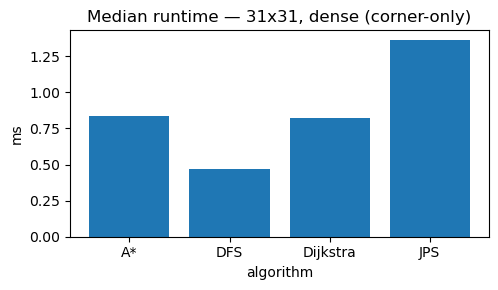

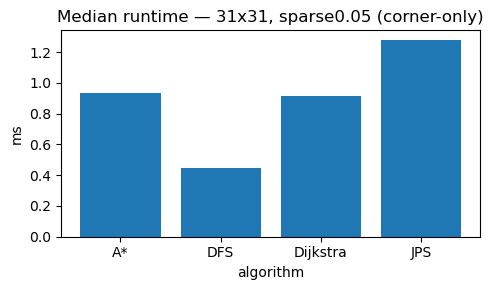

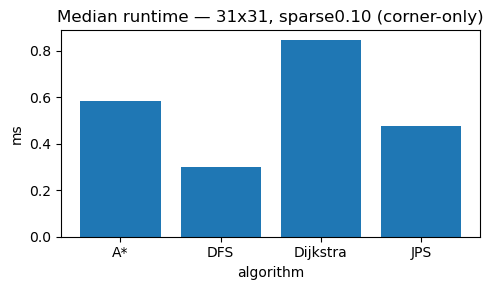

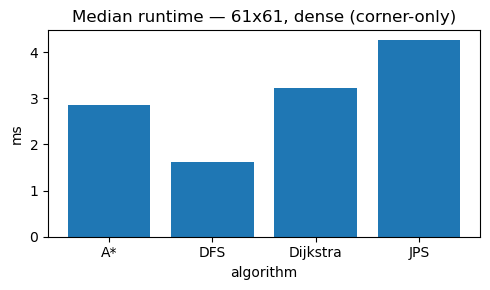

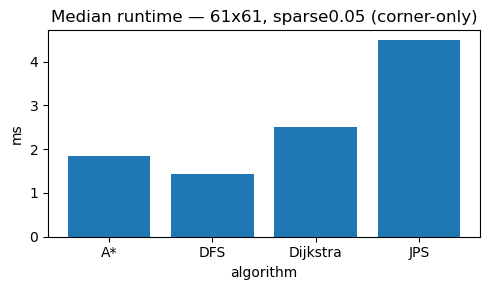

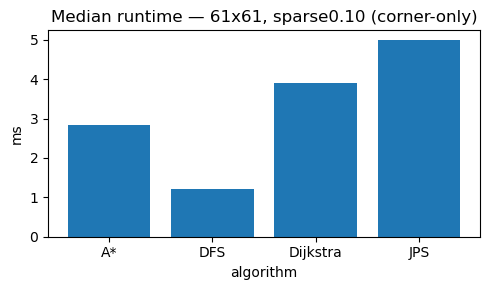

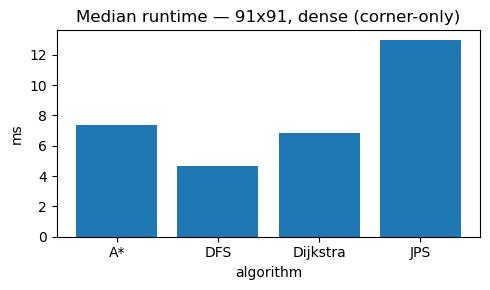

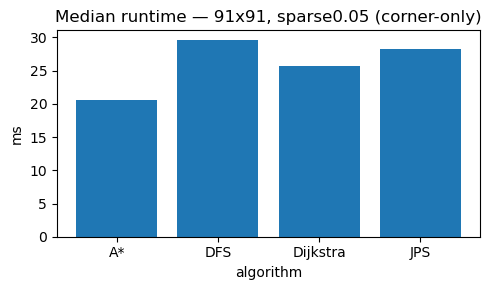

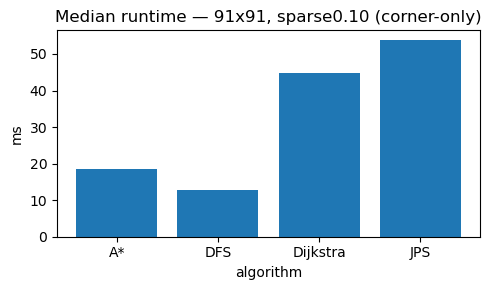

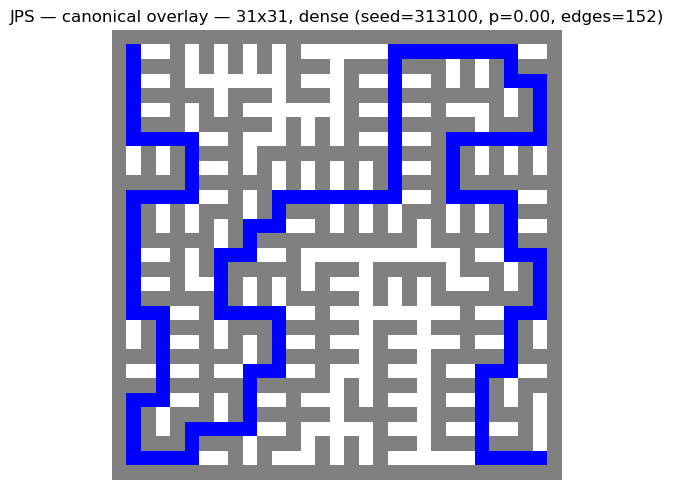

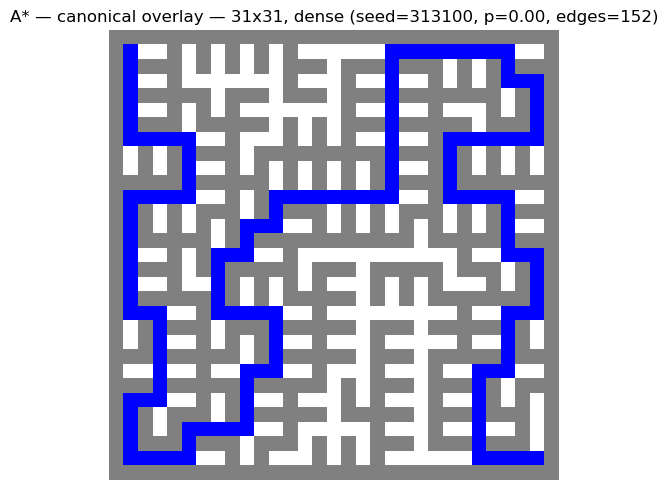

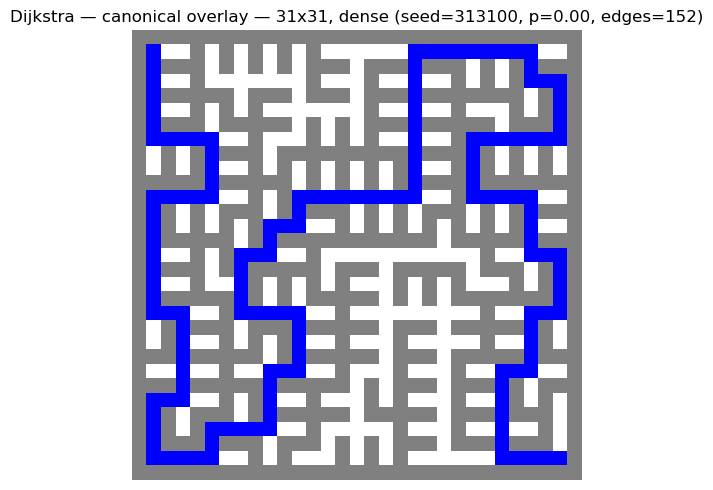

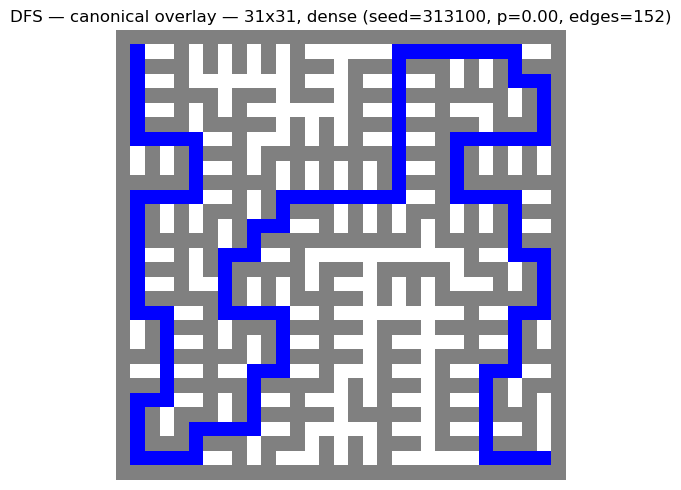

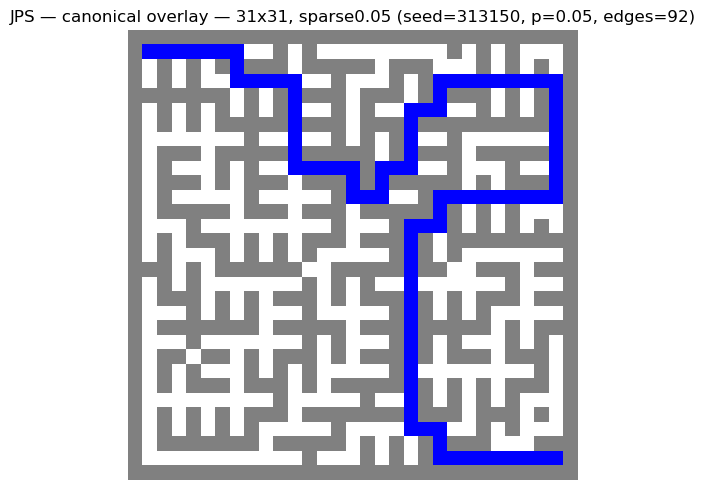

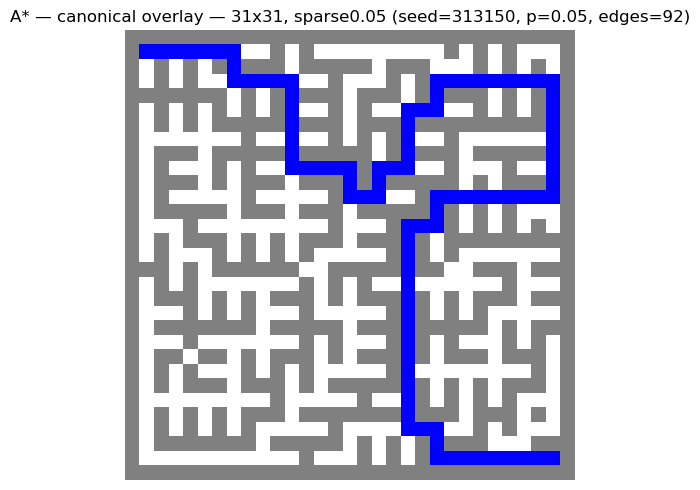

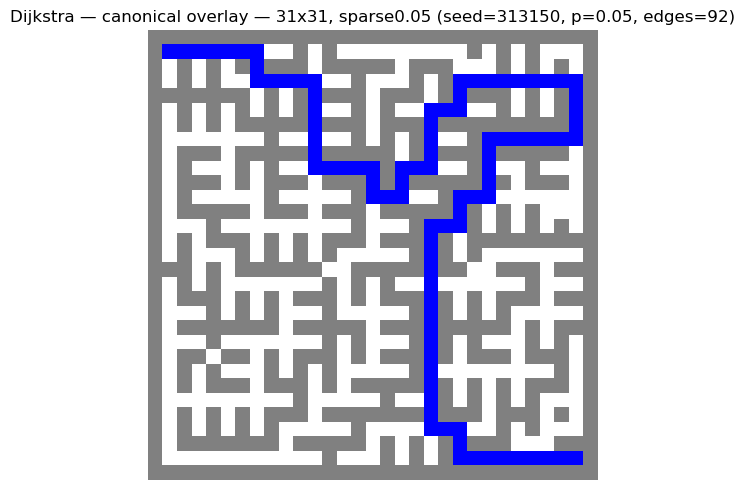

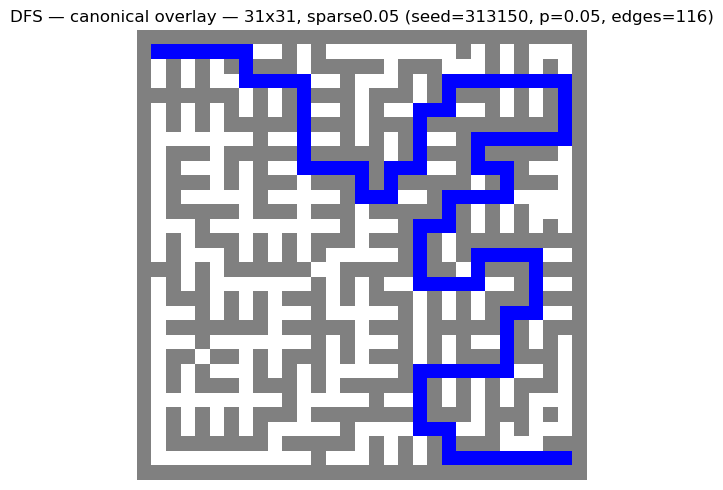

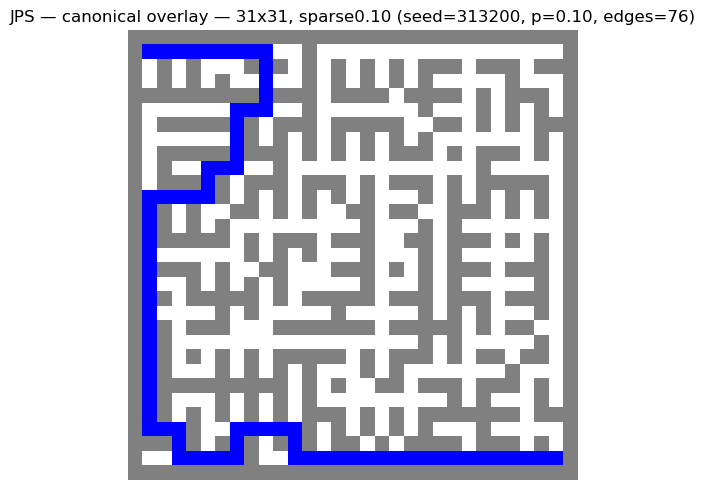

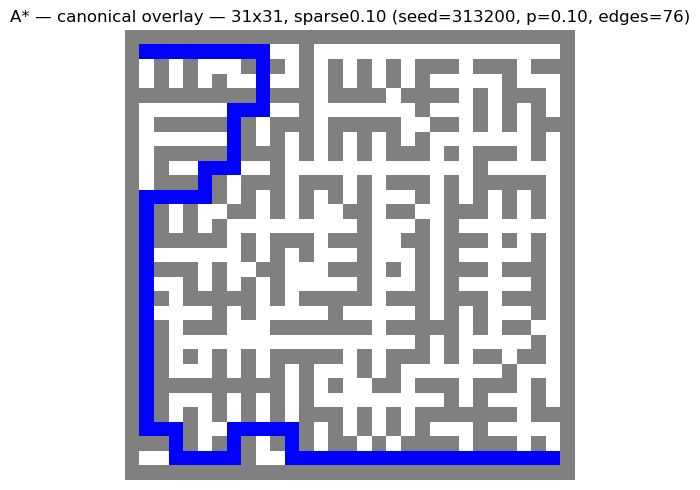

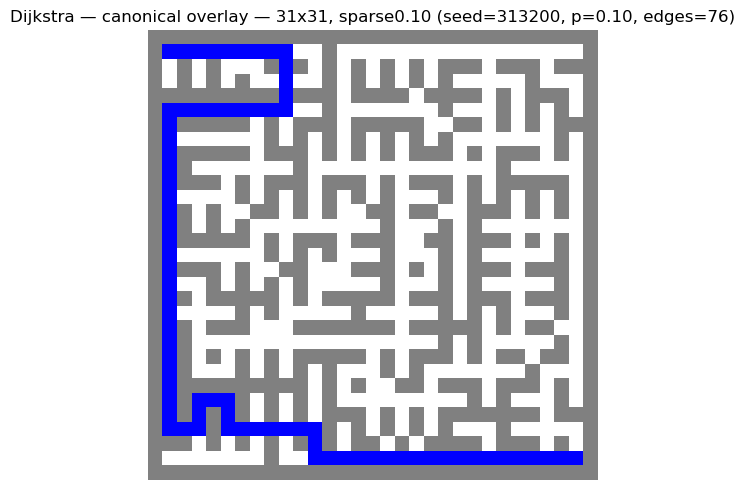

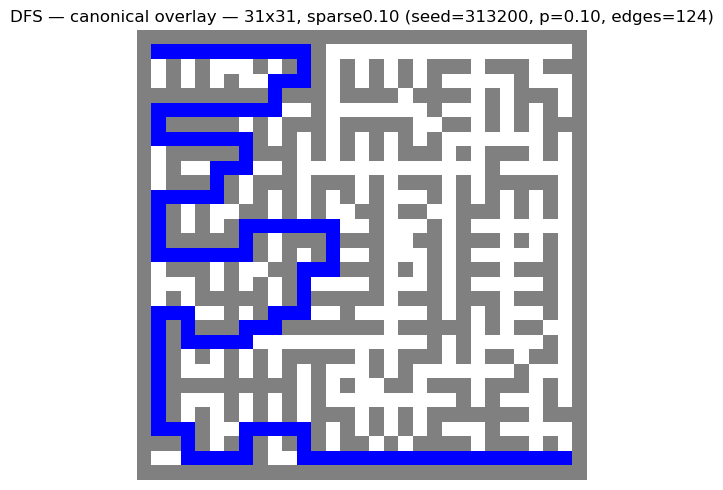

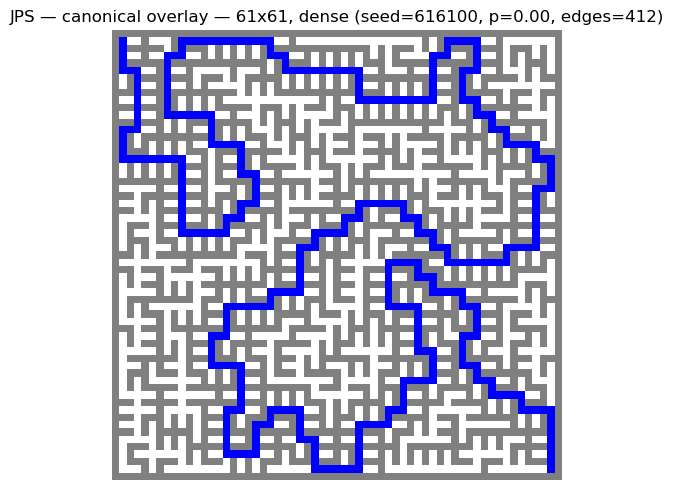

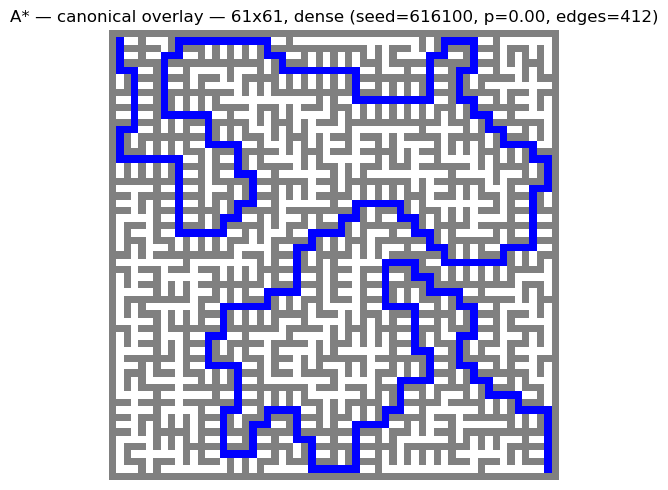

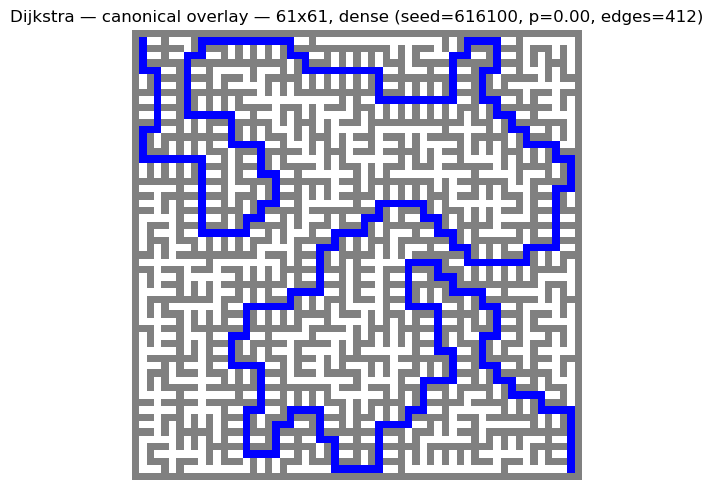

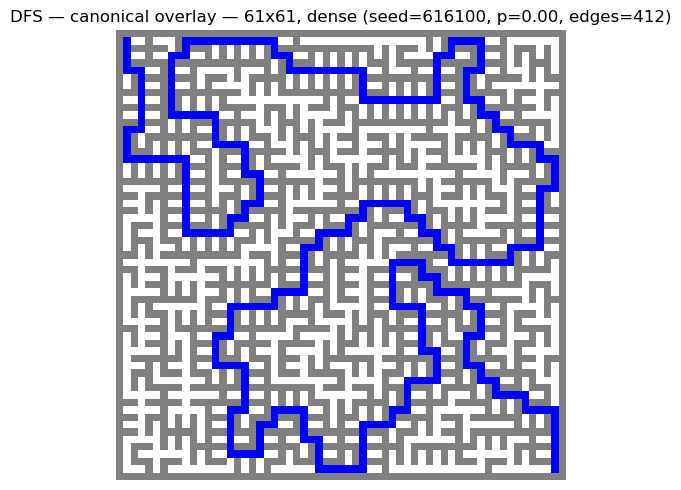

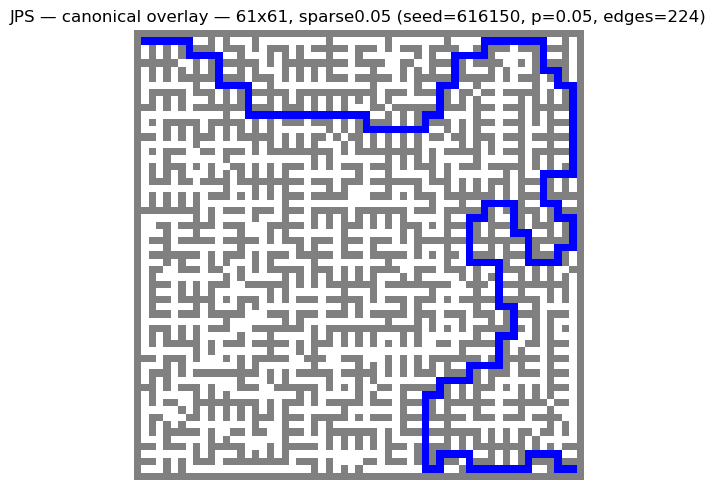

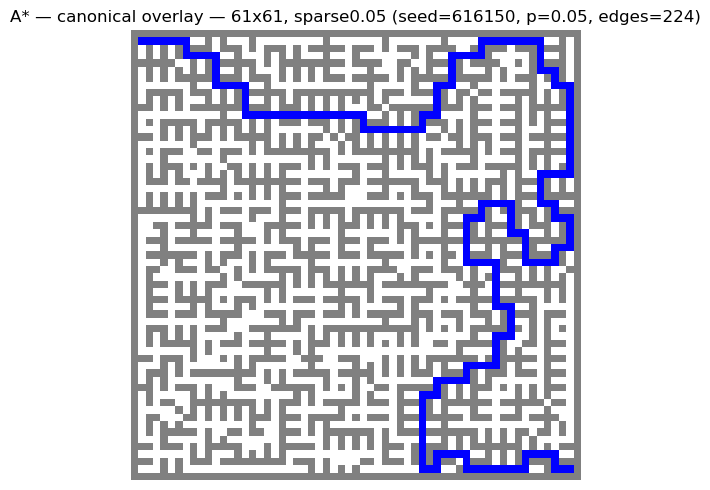

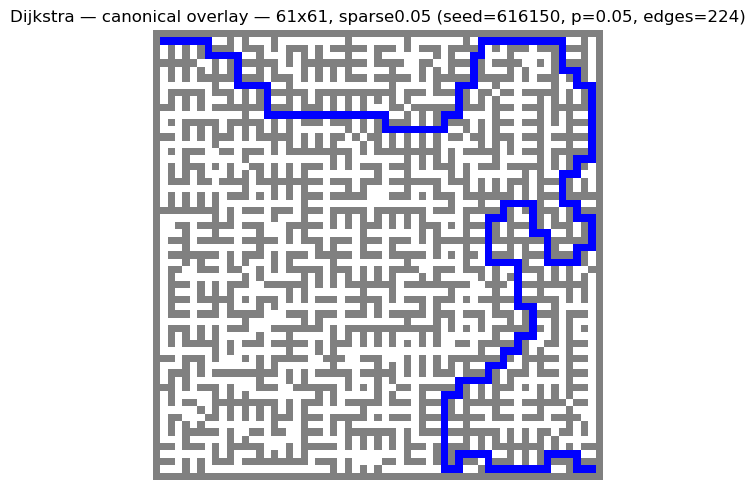

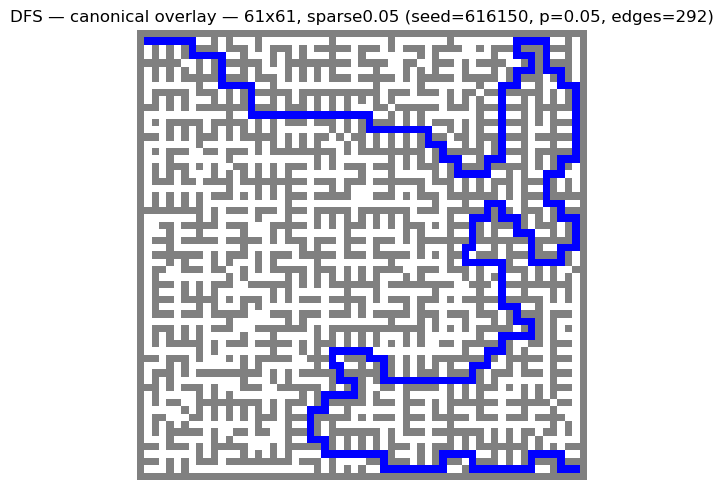

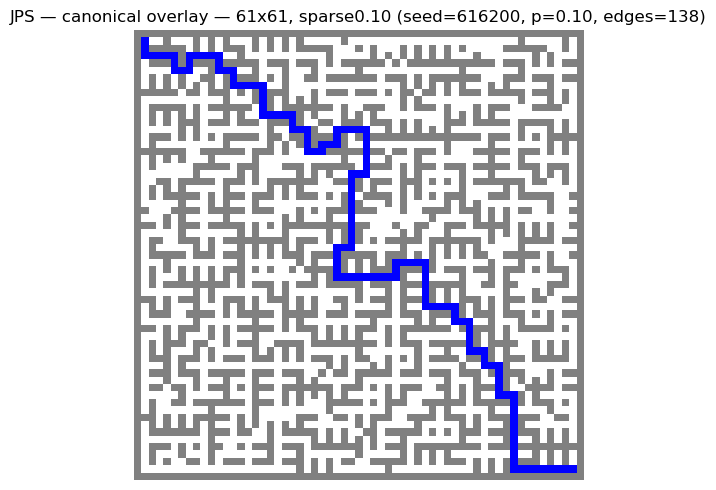

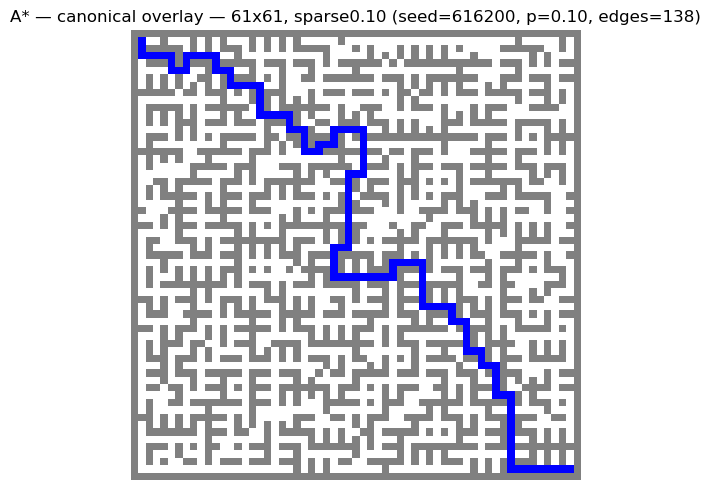

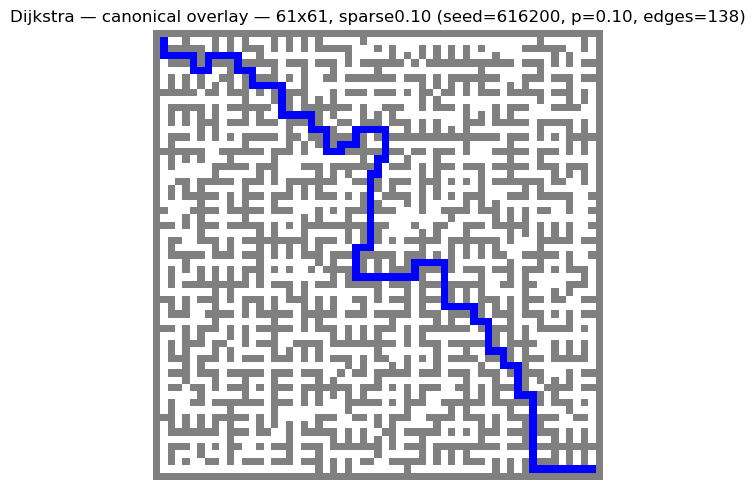

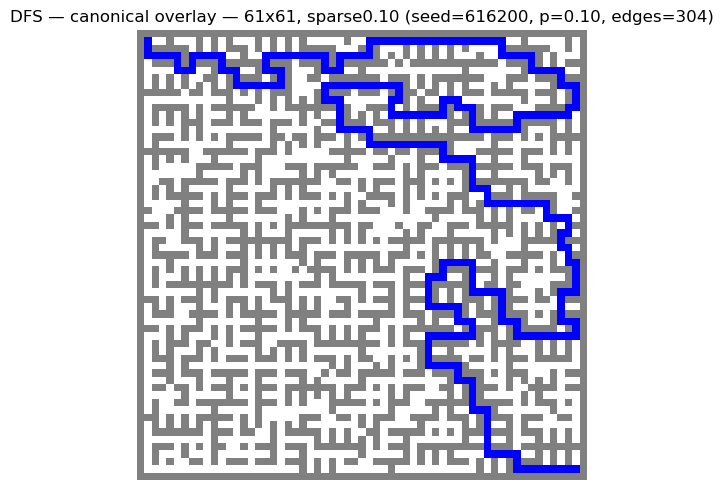

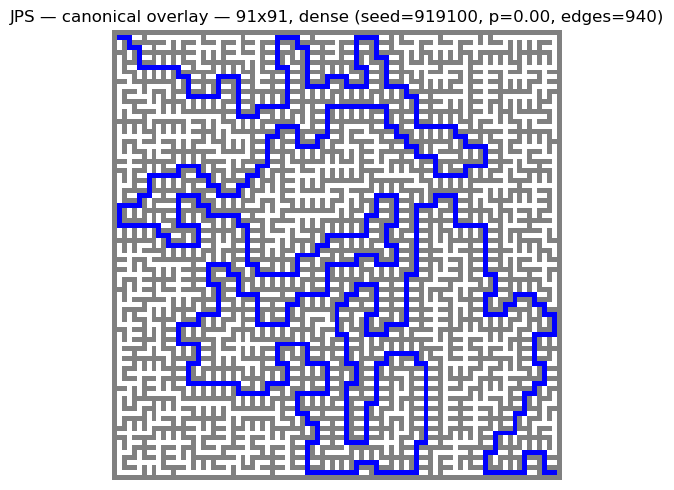

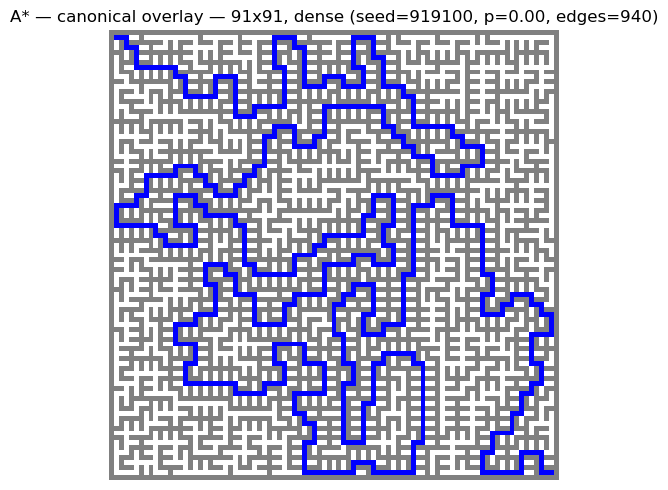

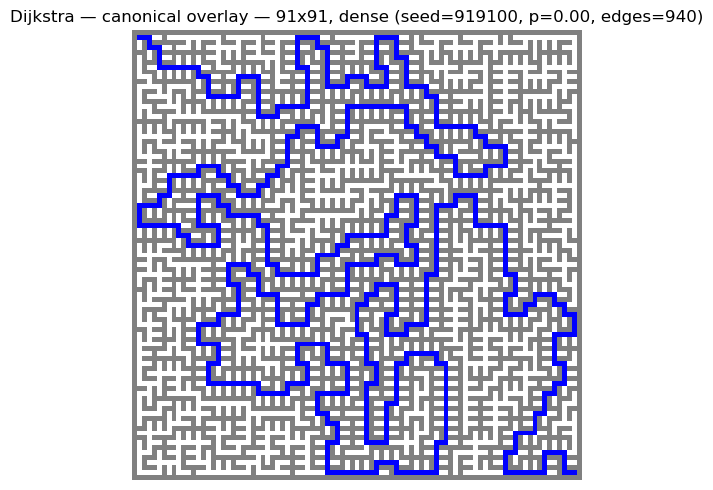

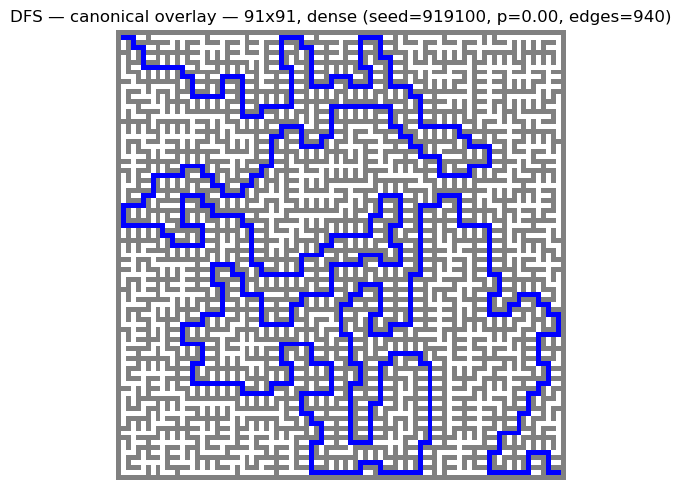

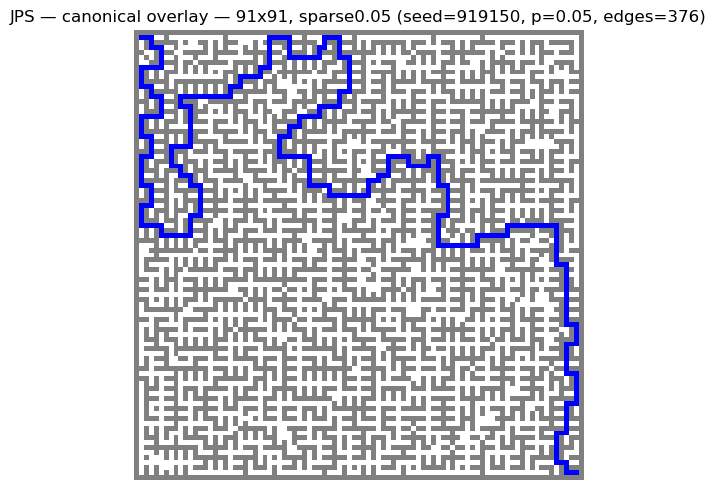

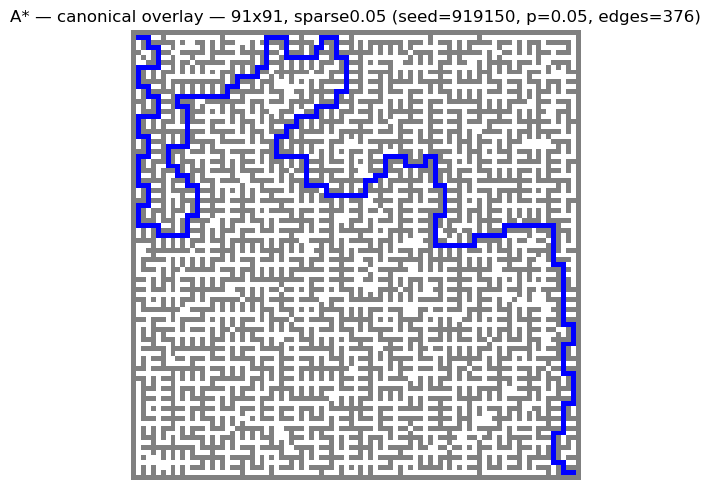

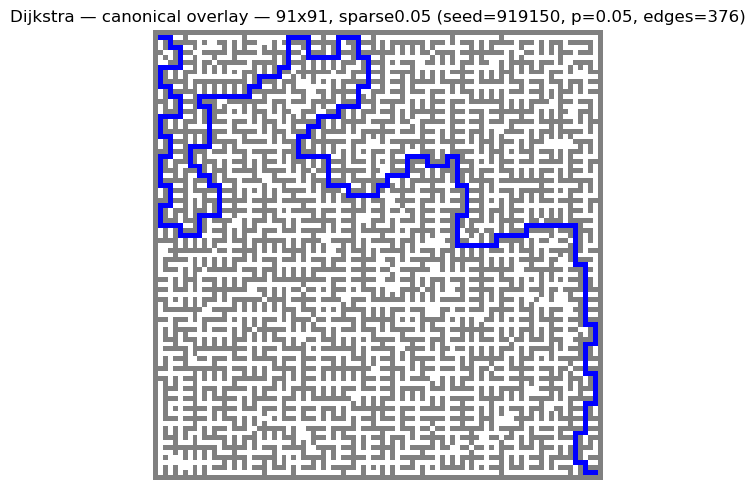

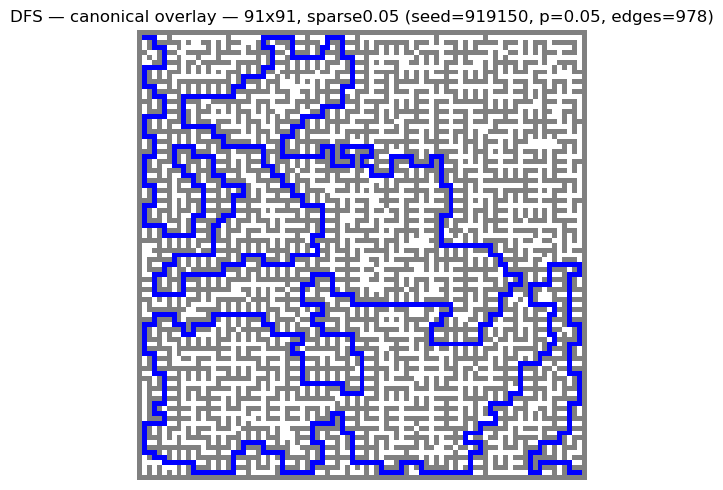

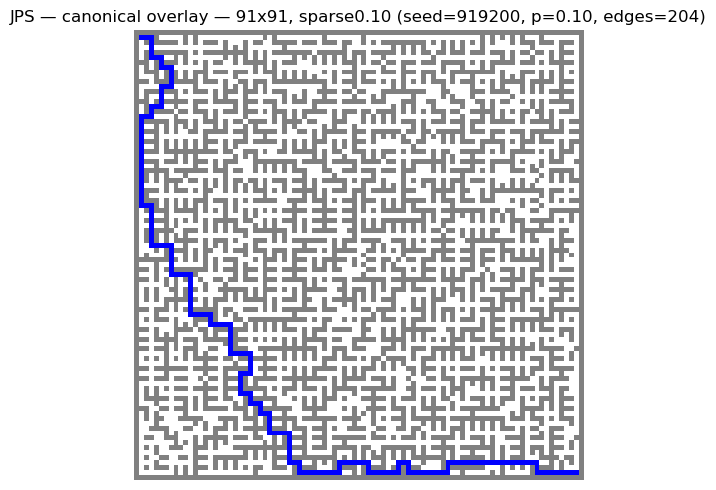

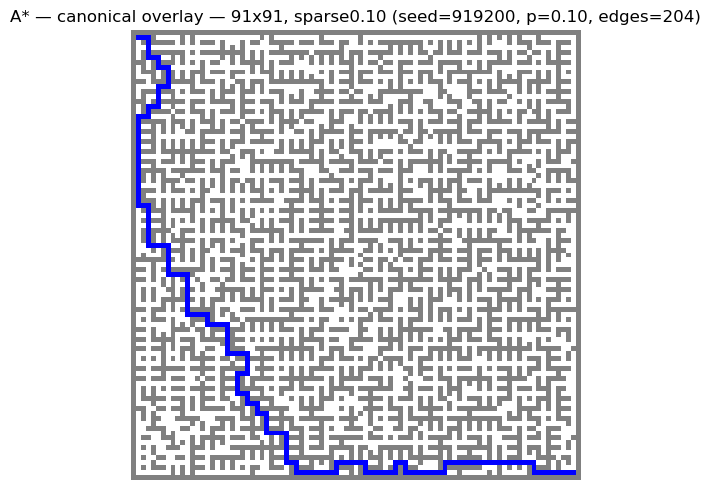

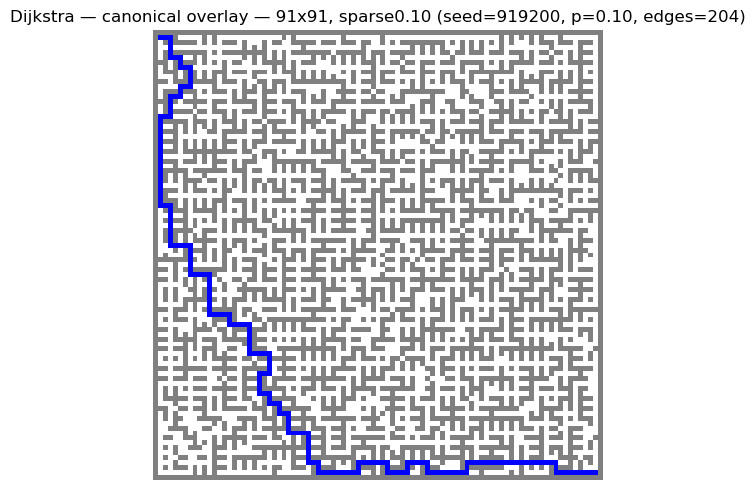

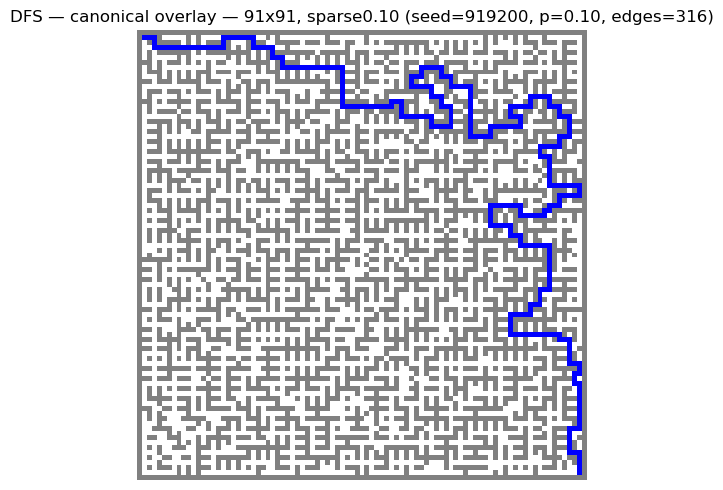

In [7]:

# Corner-only summaries and canonical overlays
def corner_view(df:pd.DataFrame)->pd.DataFrame: return df[df["is_corner"]==1].copy()

def summarize_corner_medians(df:pd.DataFrame)->pd.DataFrame:
    corner=corner_view(df)
    return (corner.groupby(["size","map_type","algo"])[["runtime_ms","expanded"]]
                  .median().reset_index())

med_table=summarize_corner_medians(df)
print(med_table.sort_values(["size","map_type","runtime_ms"]).head(12))

for (size,mtype),sub in med_table.groupby(["size","map_type"]):
    plt.figure(figsize=(5,3))
    plt.bar(sub["algo"],sub["runtime_ms"])
    plt.title(f"Median runtime — {size}, {mtype} (corner-only)")
    plt.ylabel("ms"); plt.xlabel("algorithm"); plt.tight_layout()
    fname=f"corner_median_runtime_{size}_{mtype}".replace("*","star").replace(" ","_")
    plt.savefig(os.path.join(ARTIFACTS,f"{fname}.png"),dpi=160); plt.show()

def best_run_heatmap(grid,path,title):
    img=grid.copy(); H,W=img.shape
    for y,x in path:
        if 0<=y<H and 0<=x<W: img[y,x]=2
    cmap=ListedColormap(["white","gray","blue"])
    plt.figure(figsize=(5,5)); plt.imshow(img,cmap=cmap,interpolation="none",vmin=0,vmax=2)
    plt.axis("off"); plt.title(title); plt.tight_layout()
    fname=title.replace("*","star").replace(" ","_").replace(",","").replace("—","-")
    plt.savefig(os.path.join(ARTIFACTS,f"overlay_{fname}.png"),dpi=160); plt.show()

def canonical_overlays_corners(df:pd.DataFrame)->None:
    fn={"A*":astar_metrics,"DFS":dfs_metrics,"Dijkstra":dijkstra_metrics,"JPS":jps_metrics}
    for size in sorted(df["size"].unique().tolist()):
        H,W=map(int,size.split("x"))
        start,end=(1,1),(H-2,W-2)
        for mtype in sorted(df["map_type"].unique().tolist()):
            base=df[(df["size"]==size)&(df["map_type"]==mtype)&(df["is_corner"]==1)]
            if base.empty: continue
            r=base.iloc[0]; seed=int(r["seed"]); pval=float(r["p"])
            M=generate_maze_dfs_seeded(W|1,H|1,seed=seed)
            G=M if pval==0.0 else add_loops(M,p=pval,seed=seed)
            for algo in ["JPS","A*","Dijkstra","DFS"]:
                out=fn[algo](G,start,end); path=out.get("path",[])
                title=f"{algo} — canonical overlay — {size}, {mtype} (seed={seed}, p={pval:.2f}, edges={max(0,len(path)-1)})"
                best_run_heatmap(G,path,title)

canonical_overlays_corners(df)


In [8]:
# pick one failing JPS row
cond = (df["algo"] == "JPS") & (df["size"] == "31x31") & (df["map_type"] == "sparse0.10")
bad = df[cond].iloc[0]

size  = bad["size"]
pval  = float(bad["p"])
seed  = int(bad["seed"])
start = (int(bad["start_y"]), int(bad["start_x"]))
end   = (int(bad["end_y"]),   int(bad["end_x"]))

print("Replaying:", size, "map_type", bad["map_type"], "seed", seed, "p", pval, "start/end", start, "->", end)

H, W = map(int, size.split("x"))
base = generate_maze_dfs_seeded(W|1, H|1, seed=seed)
maze = add_loops(base, p=pval, seed=seed) if pval > 0 else base

jp_path, steps = solve_maze_jps_core(maze, start, end)
print("Core JPS jump points length:", len(jp_path))

if jp_path:
    step_path8 = _stitch_jump_path_to_8(jp_path, maze)
    print("Stitched 8-connected path length:", len(step_path8))

    path4 = _path8_to_path4(maze, step_path8)
    print("4-connected converted path length:", len(path4))


Replaying: 31x31 map_type sparse0.10 seed 313200 p 0.1 start/end (1, 1) -> (29, 29)
Core JPS jump points length: 31
Stitched 8-connected path length: 60
4-connected converted path length: 0


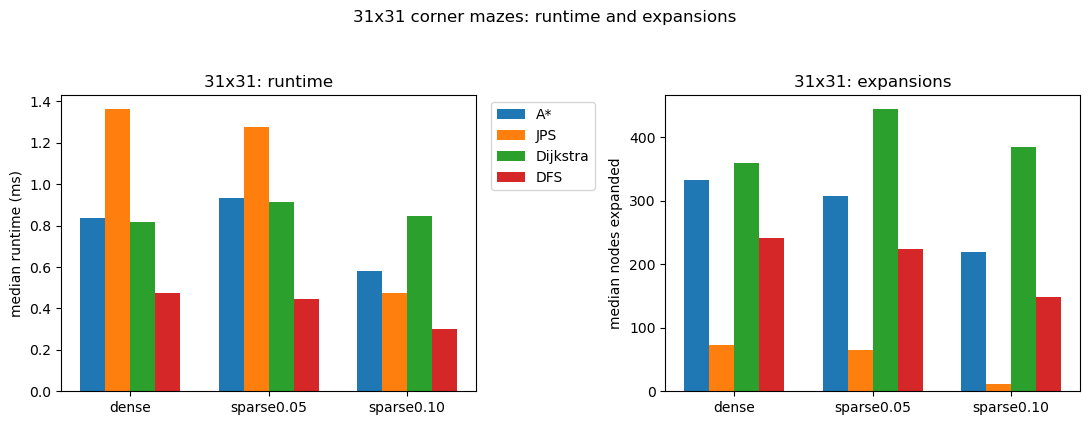

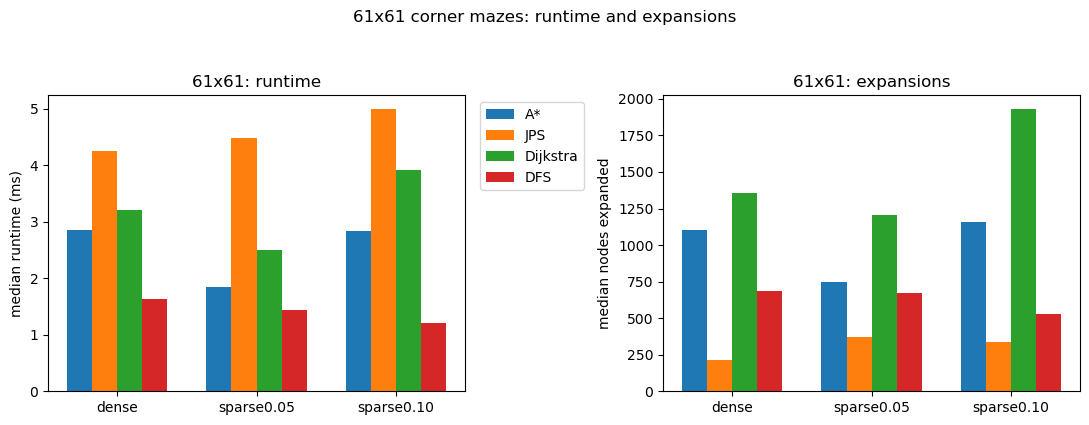

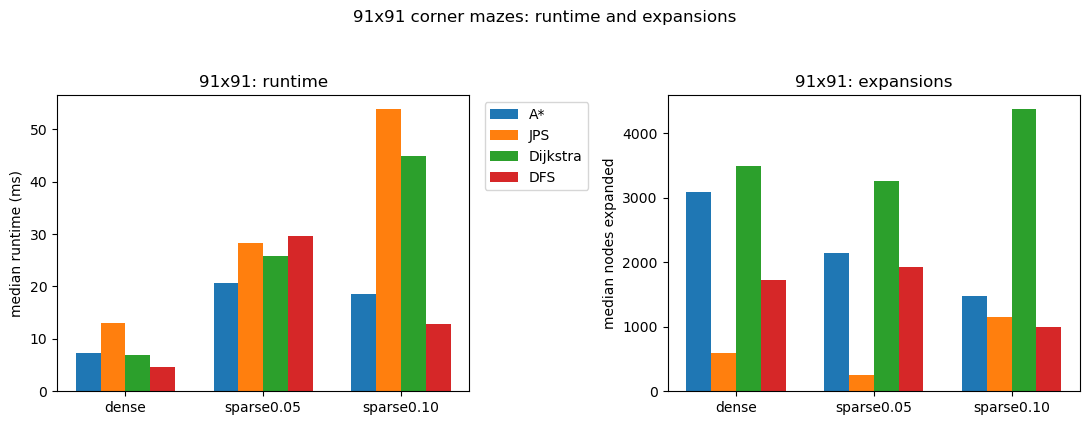

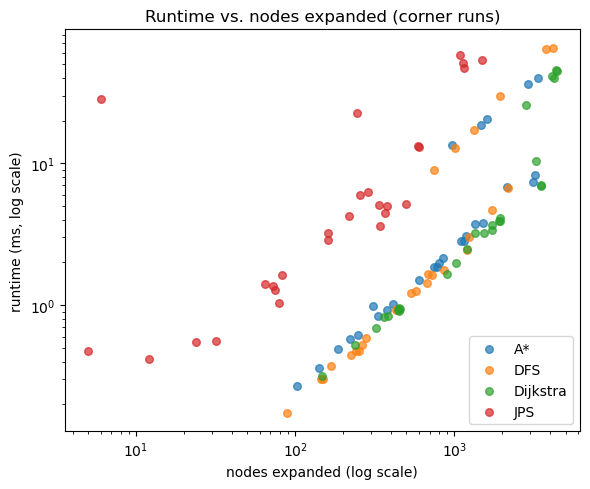

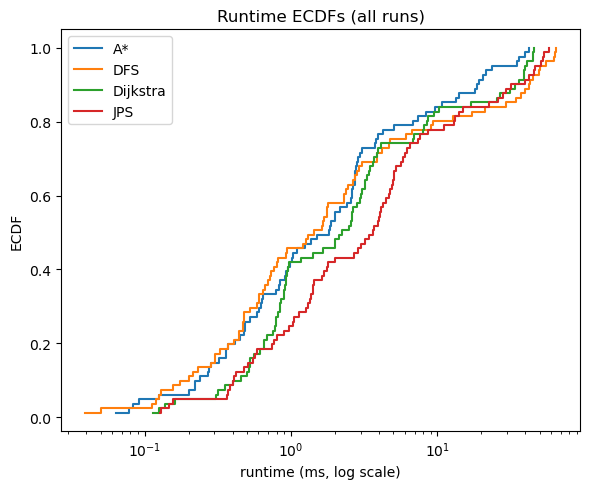

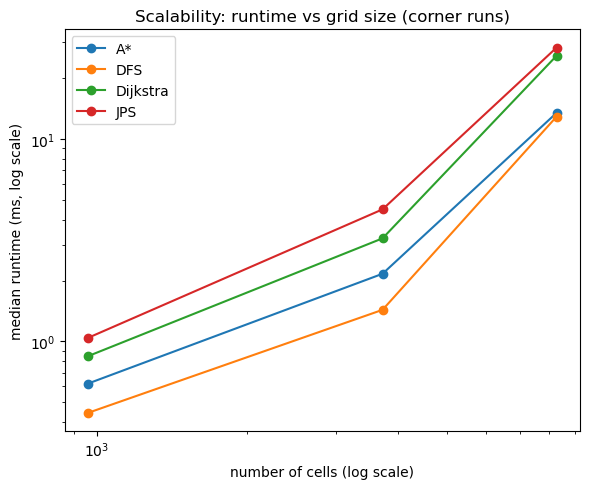

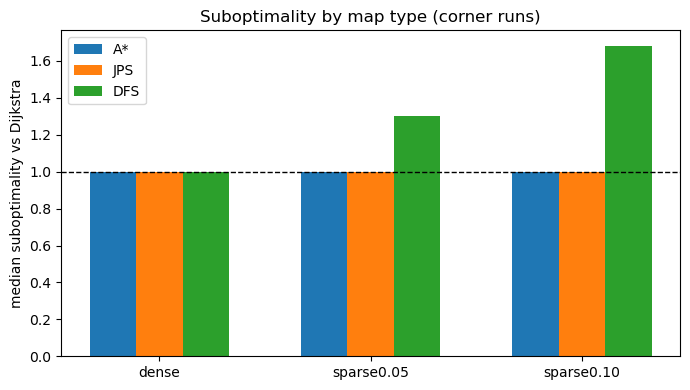

canonical_overlays() not defined in this notebook; skip Figure 8 binding or call your overlay code here.


In [9]:
# === Figure bindings for LaTeX ===
# This cell assumes you already have artifacts_all_in_one/runs.csv
# produced by the final_grid_benchmark notebook.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------------------------------------------------------------
# 0) Load results and prepare common helpers
# ---------------------------------------------------------------------
ARTIFACTS = Path("artifacts_all_in_one")
ARTIFACTS.mkdir(exist_ok=True)

csv_path = ARTIFACTS / "runs.csv"
df = pd.read_csv(csv_path)

# keep only successful runs
df_ok = df[df["success"] == 1].copy()

# number of cells from "31x31" -> 961
df_ok["cells"] = (
    df_ok["size"]
    .str.split("x")
    .apply(lambda ab: int(ab[0]) * int(ab[1]))
)

map_order  = ["dense", "sparse0.05", "sparse0.10"]
algo_order = ["A*", "JPS", "Dijkstra", "DFS"]  # adjust ordering if you prefer


# ---------------------------------------------------------------------
# 1) Runtime + expansions bars for 31x31, 61x61, 91x91
#    LaTeX labels: fig:runtime31, fig:runtime61, fig:runtime91
# ---------------------------------------------------------------------
def make_runtime_bars(size_str: str, filename: str):
    sub = df_ok[(df_ok["size"] == size_str) & (df_ok["is_corner"] == 1)]
    med = (
        sub.groupby(["map_type", "algo"])[["runtime_ms", "expanded"]]
        .median()
        .reset_index()
    )

    med["map_type"] = pd.Categorical(med["map_type"],
                                     categories=map_order,
                                     ordered=True)
    med["algo"] = pd.Categorical(med["algo"],
                                  categories=algo_order,
                                  ordered=True)
    med = med.sort_values(["map_type", "algo"])

    x = np.arange(len(map_order))
    width = 0.18

    fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharex=True)

    for i, metric in enumerate(["runtime_ms", "expanded"]):
        ax = axes[i]
        for j, algo in enumerate(algo_order):
            vals = [
                med.loc[
                    (med["map_type"] == m) & (med["algo"] == algo),
                    metric
                ].values[0]
                if not med[
                    (med["map_type"] == m) & (med["algo"] == algo)
                ].empty else np.nan
                for m in map_order
            ]
            ax.bar(x + (j - 1.5) * width, vals, width, label=algo)
        ax.set_xticks(x)
        ax.set_xticklabels(map_order)
        if metric == "runtime_ms":
            ax.set_ylabel("median runtime (ms)")
            ax.set_title(f"{size_str}: runtime")
        else:
            ax.set_ylabel("median nodes expanded")
            ax.set_title(f"{size_str}: expansions")

    axes[0].legend(loc="upper left", bbox_to_anchor=(1.02, 1.0))
    fig.suptitle(f"{size_str} corner mazes: runtime and expansions", y=1.05)
    fig.tight_layout()
    fig.savefig(ARTIFACTS / filename, dpi=200, bbox_inches="tight")
    plt.show()


make_runtime_bars("31x31", "fig_runtime31.png")  # -> Figure 1
make_runtime_bars("61x61", "fig_runtime61.png")  # -> Figure 2
make_runtime_bars("91x91", "fig_runtime91.png")  # -> Figure 3


# ---------------------------------------------------------------------
# 2) Pareto plot: runtime vs expanded
#    LaTeX label: fig:pareto
# ---------------------------------------------------------------------
def make_pareto(filename: str):
    sub = df_ok[df_ok["is_corner"] == 1]
    fig, ax = plt.subplots(figsize=(6, 5))
    for algo, g in sub.groupby("algo"):
        ax.scatter(g["expanded"], g["runtime_ms"],
                   s=30, alpha=0.7, label=algo)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("nodes expanded (log scale)")
    ax.set_ylabel("runtime (ms, log scale)")
    ax.set_title("Runtime vs. nodes expanded (corner runs)")
    ax.legend()
    fig.tight_layout()
    fig.savefig(ARTIFACTS / filename, dpi=200, bbox_inches="tight")
    plt.show()


make_pareto("fig_pareto.png")  # -> Figure 4


# ---------------------------------------------------------------------
# 3) ECDFs of runtime
#    LaTeX label: fig:ecdf
# ---------------------------------------------------------------------
def ecdf(values: np.ndarray):
    x = np.sort(values)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y


def make_ecdf(filename: str):
    fig, ax = plt.subplots(figsize=(6, 5))
    for algo, g in df_ok.groupby("algo"):
        x, y = ecdf(g["runtime_ms"].values)
        ax.step(x, y, where="post", label=algo)
    ax.set_xscale("log")
    ax.set_xlabel("runtime (ms, log scale)")
    ax.set_ylabel("ECDF")
    ax.set_title("Runtime ECDFs (all runs)")
    ax.legend()
    fig.tight_layout()
    fig.savefig(ARTIFACTS / filename, dpi=200, bbox_inches="tight")
    plt.show()


make_ecdf("fig_ecdf.png")  # -> Figure 5


# ---------------------------------------------------------------------
# 4) Scalability curves: runtime vs cells (log–log)
#    LaTeX label: fig:scaling
# ---------------------------------------------------------------------
def make_scaling(filename: str):
    sub = df_ok[df_ok["is_corner"] == 1]
    med = (
        sub.groupby(["algo", "cells"])
        ["runtime_ms"]
        .median()
        .reset_index()
        .sort_values("cells")
    )

    fig, ax = plt.subplots(figsize=(6, 5))
    for algo, g in med.groupby("algo"):
        ax.plot(g["cells"], g["runtime_ms"], marker="o", label=algo)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("number of cells (log scale)")
    ax.set_ylabel("median runtime (ms, log scale)")
    ax.set_title("Scalability: runtime vs grid size (corner runs)")
    ax.legend()
    fig.tight_layout()
    fig.savefig(ARTIFACTS / filename, dpi=200, bbox_inches="tight")
    plt.show()


make_scaling("fig_scaling.png")  # -> Figure 6


# ---------------------------------------------------------------------
# 5) Suboptimality bars
#    LaTeX label: fig:subopt
# ---------------------------------------------------------------------
def make_subopt(filename: str):
    sub = df_ok[(df_ok["is_corner"] == 1) & (df_ok["algo"] != "Dijkstra")]
    med = (
        sub.groupby(["map_type", "algo"])
        ["suboptimality"]
        .median()
        .reset_index()
    )

    med["map_type"] = pd.Categorical(med["map_type"],
                                     categories=map_order,
                                     ordered=True)
    med["algo"] = pd.Categorical(med["algo"],
                                  categories=["A*", "JPS", "DFS"],
                                  ordered=True)
    med = med.sort_values(["map_type", "algo"])

    x = np.arange(len(map_order))
    width = 0.22

    fig, ax = plt.subplots(figsize=(7, 4))
    for j, algo in enumerate(["A*", "JPS", "DFS"]):
        vals = [
            med.loc[
                (med["map_type"] == m) & (med["algo"] == algo),
                "suboptimality"
            ].values[0]
            if not med[
                (med["map_type"] == m) & (med["algo"] == algo)
            ].empty else np.nan
            for m in map_order
        ]
        ax.bar(x + (j - 1) * width, vals, width, label=algo)

    ax.axhline(1.0, color="k", linestyle="--", linewidth=1)
    ax.set_xticks(x)
    ax.set_xticklabels(map_order)
    ax.set_ylabel("median suboptimality vs Dijkstra")
    ax.set_title("Suboptimality by map type (corner runs)")
    ax.legend()
    fig.tight_layout()
    fig.savefig(ARTIFACTS / filename, dpi=200, bbox_inches="tight")
    plt.show()


make_subopt("fig_subopt.png")  # -> Figure 7


# ---------------------------------------------------------------------
# 6) Canonical overlays
#    LaTeX label: fig:overlays
#
# NOTE: this part assumes you already have a function `canonical_overlays`
# in the notebook that draws overlays and saves files named like
#   overlay_<algo>_<size>_<map_type>.png
# If not, comment this block out or replace it with your own overlay code.
# ---------------------------------------------------------------------
try:
    # regenerate per-algorithm overlays and save them
    canonical_overlays(df_ok, use_longest=True, save=True)

    # pick one representative overlay (e.g., any 61x61 sparse0.05 file)
    overlay_candidates = list(ARTIFACTS.glob("overlay_*61x61_sparse0.05*.png"))
    if overlay_candidates:
        overlay_src = overlay_candidates[0]
        overlay_dst = ARTIFACTS / "fig_overlays.png"
        overlay_dst.write_bytes(overlay_src.read_bytes())
        print("Saved canonical overlay binding as:", overlay_dst)
    else:
        print("No overlay_*61x61_sparse0.05*.png found; "
              "keep using your existing overlay figure manually.")
except NameError:
    print("canonical_overlays() not defined in this notebook; "
          "skip Figure 8 binding or call your overlay code here.")


Overlay condition: size=61x61, map_type=sparse0.05, seed=616150, p=0.05
Start/end: (1, 1) -> (59, 59)
A*: path length = 225
JPS: path length = 225
Dijkstra: path length = 225
DFS: path length = 293


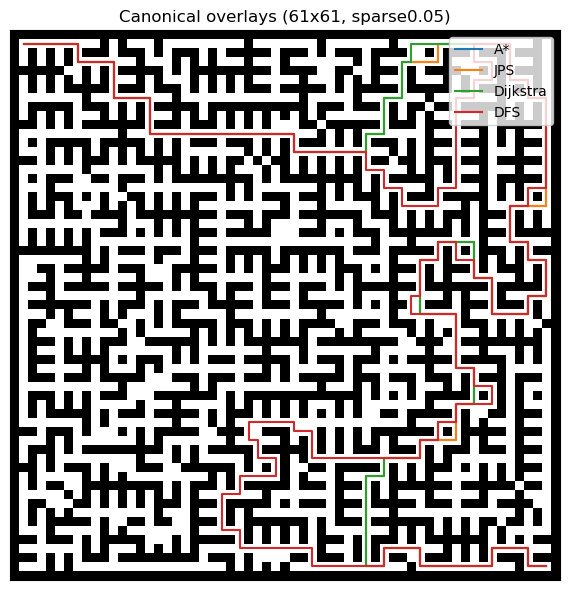

Saved Figure 8 overlay to: artifacts_all_in_one\fig_overlays.png


In [10]:
# === Figure 8: canonical overlays on one representative maze ===
# This cell creates artifacts_all_in_one/fig_overlays.png
# and matches the LaTeX label \label{fig:overlays}.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 1) Choose a representative condition for the overlay
#    Prefer 61x61 sparse0.05 corner; fall back if not present.
cond = (
    (df_ok["size"] == "61x61")
    & (df_ok["map_type"] == "sparse0.05")
    & (df_ok["is_corner"] == 1)
)

if df_ok[cond].empty:
    cond = (
        (df_ok["size"] == "61x61")
        & (df_ok["map_type"] == "dense")
        & (df_ok["is_corner"] == 1)
    )

if df_ok[cond].empty:
    # final fallback: any corner run
    cond = (df_ok["is_corner"] == 1)

row = df_ok[cond].iloc[0]

H, W = map(int, row["size"].split("x"))
seed = int(row["seed"])
pval = float(row["p"])

start = (int(row["start_y"]), int(row["start_x"]))
end   = (int(row["end_y"]),   int(row["end_x"]))

print("Overlay condition:",
      f"size={row['size']}, map_type={row['map_type']}, seed={seed}, p={pval:.2f}")
print("Start/end:", start, "->", end)

# 2) Rebuild the corresponding maze using your generators
base = generate_maze_dfs_seeded(W | 1, H | 1, seed=seed)
if pval == 0.0:
    grid = base
else:
    grid = add_loops(base, p=pval, seed=seed)

# 3) Run all algorithms on this maze to get their paths
paths = {}
algo_list = [
    ("A*",       astar_metrics),
    ("JPS",      jps_metrics),
    ("Dijkstra", dijkstra_metrics),
    ("DFS",      dfs_metrics),
]

for name, solver in algo_list:
    out = solver(grid, start, end)
    paths[name] = out.get("path", [])
    print(f"{name}: path length = {len(paths[name])}")

# 4) Plot overlays on the same grid
cmap = ListedColormap(["white", "black"])  # 0 = free, 1 = wall

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(grid, cmap=cmap, interpolation="none")
ax.set_xticks([])
ax.set_yticks([])

colors = {
    "A*":       "tab:blue",
    "JPS":      "tab:orange",
    "Dijkstra": "tab:green",
    "DFS":      "tab:red",
}

for name, path in paths.items():
    if not path:
        continue
    ys = [y for (y, x) in path]
    xs = [x for (y, x) in path]
    ax.plot(xs, ys, linewidth=1.5, label=name, color=colors.get(name, "k"))

ax.set_title(f"Canonical overlays ({row['size']}, {row['map_type']})")
ax.legend(loc="upper right")
fig.tight_layout()

out_path = ARTIFACTS / "fig_overlays.png"
fig.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()

print("Saved Figure 8 overlay to:", out_path)
